# Multiple Ring Neurons Experiment

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
from datetime import datetime as dt
import os

In [2]:
COLORS = mcolors.TABLEAU_COLORS
COLOR_NAMES = [k.replace('tab:', '') for k in COLORS.keys()]
COLORS = list(COLORS.values())

# Utilities

In [3]:
def create_frame(ax, xs, ys, t) -> None:
    '''
    :param xs list: a list of the x-values of the doodle
    :param ys list: a list of the y-values of the doodle
    :param t int: the current timestep in the doodle

    TODO file naming
    '''
    ax.plot(xs[:(t+1)], ys[:(t+1)], color = 'gray' )
    ax.plot(xs[t], ys[t], color = 'black', marker = 'o' )
    ax.set_xlim([-1, 1])
    ax.set_xlabel('x', fontsize = 14)
    ax.set_ylim([-1, 1])
    ax.set_ylabel('y', fontsize = 14)
    ax.set_title(f'Step {t}', fontsize=14)

In [33]:
def create_frame_multiple_pens(ax, xs, ys, pen_labels, pen_colors, t) -> None:
    '''
    :param xs list: a list of the different x-series of the doodles
    :param ys list: a list of the different y-series of the doodles
    :param t int: the current timestep in the doodle

    TODO file naming
    '''
    assert len(xs) == len(ys), "xs and ys shape doesn't match!"
    for i in range(len(xs)):
        ax.plot(xs[i][:t+1], ys[i][:t+1], color=pen_colors[i], alpha=0.5, label=pen_labels[i])
        ax.plot(xs[i][t], ys[i][t], color=pen_colors[i], alpha=0.8, marker = 'o')


        # ax.plot(xs_no_mom[:(t+1)], ys_no_mom[:(t+1)], color = 'gray', label='No Momentum')
        

        # ax.plot(xs_with_mom[:(t+1)], ys_with_mom[:(t+1)], color = 'pink', label='With Momentum')
        # ax.plot(xs_with_mom[t], ys_with_mom[t], color = 'red', marker = 'o')

        # ax.plot(xs_new_mom[:(t+1)], ys_new_mom[:(t+1)], color = 'cyan', label='New Momentum')
        # ax.plot(xs_new_mom[t], ys_new_mom[t], color = 'blue', marker = 'o')

    # ax.set_xlim([-2, 2])
    ax.set_xlabel('x', fontsize = 14)
    # ax.set_ylim([-2, 2])
    ax.set_ylabel('y', fontsize = 14)
    ax.set_title(f'Step {t}', fontsize=14)
    ax.legend()

# Model Definition

## Equations

### Equations

Activation: 

$\frac{dv_i}{dt}=\frac{1}{\tau}(-\lambda u_i v_i + I_i' (1 - \alpha \sum\limits_{\substack{j \in R \\ j \ne i}}z_j));$

Input Depletion:

$\frac{dI_i'}{dt} = -\varphi I_i z_i$

Deactivation: 

$\frac{du_i}{dt}=-\rho u_i + \gamma I_i' \frac{z_i}{c_i + \epsilon};$

Output: 

$z_i=f(v_i)=\frac{1}{1+e^{-\beta (v_i - \mu)}};$

In [5]:
def sigmoid(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

## Neurons

In [6]:
NUM_UNITS = 36
directions_deg = [i * 360 / NUM_UNITS for i in range(NUM_UNITS)] # define directions_deg so we can use these for easy plotting
directions_rad = np.array([np.deg2rad(dir) for dir in directions_deg]) # convert degrees to radians for headings
headings = np.array([[np.cos(dir), np.sin(dir)] for dir in directions_rad]) # headings is used for later calculations

## Driver Code

In [7]:
def doodle(t, state, p):
    '''
    Because we can't provide a vectorized state (i.e. state can't be 2-d in solve_ivp()),
    we hide the two vectors in state, so state is a vector of [v, u], 
    where v and u are both vectors of length `num_units`.
    
    Then, we can handle the change in v and change in u separately, 
    and concat them back together to be returned as the new state.
    '''
    v = state[0:p['N']]
    u = state[p['N']:2*p['N']]
    I_prime = state[2*p['N']:]

    assert set([v.shape[0], u.shape[0], I_prime.shape[0]]) == set([p['N']]), f"State's shapes don't match! {v.shape, u.shape, I_prime.shape}"

    z = sigmoid(v, p['beta'], p['mu'])
   
    # calculate dv/dt, du/dt, DI'/dt
    inhibition_vec = 1 - (p['eta'] * np.dot(z, 1 - np.eye(p['N']))) # multiply by the sum of *other* neuron's outputs
    dv = (1 / p['tau']) * ((-1 * p['lambda'] * u * v) + (I_prime * inhibition_vec))
    du = (-1 * p['rho'] * u) + (p['gamma'] * I_prime * (z) / (p['c'] + p['epsilon']))
    dI_prime = -1 * p['phi'] * p['I'] * z
    
    # join v and u back together to be returned
    return np.array((dv, du, dI_prime)).reshape(3*p['N'])

### Plot all variables on one plot

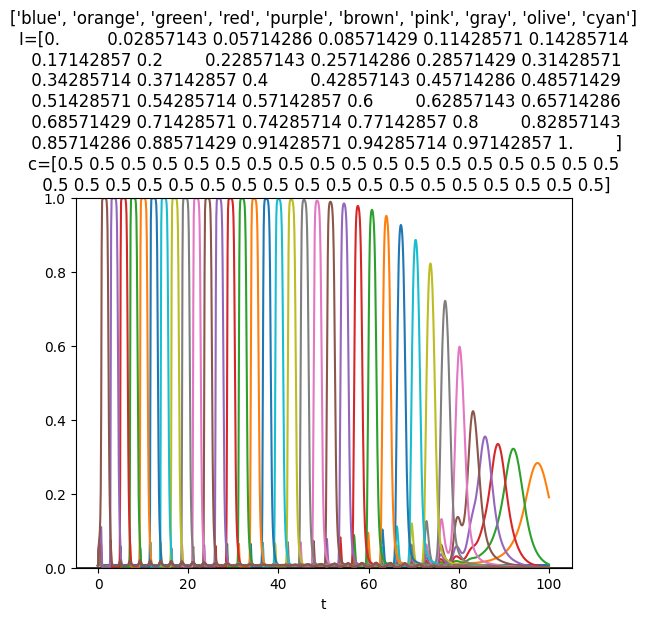

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [60]:
t_max = 100
t_steps = 1000
t = np.linspace(0, t_max, t_steps)

I = np.linspace(0, 1, NUM_UNITS)
c = np.array([0.5] * NUM_UNITS)

params = {
    'N': NUM_UNITS,
    'tau': 1.0,
    'lambda': 20,
    'eta': 1.2,
    'I': I,
    'rho': 0.1,
    'gamma': 0.1,
    'c': c,
    'epsilon': 0.00001,
    'beta': 50.0,
    'mu': 0.1,
    'phi': 0.5,
    'alpha': 0.3
}


v = np.zeros(params['N'])
u = np.zeros(params['N'])

state = np.array((v, u, I)).reshape(3*params['N'])
result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(min(t), max(t)), t_eval=t, y0=state)
v_series = result.y[:params['N'],]
z_series = sigmoid(v_series, params['beta'], params['mu'])
u_series = result.y[params['N']:2*params['N'],]
I_prime_series = result.y[2*params['N']:,]

fig, axs = plt.subplots()
table_text = pd.DataFrame(columns=['Rank', 'Direction (deg)', 'I-value', 'c-value', 'Plot Color']) # text for the table containing N rows, and 5 columns: rank, direction, I_value, c_value, plotting color 

for i in np.argsort(I):
    color = COLORS[i % len(COLORS)]
    # plt.plot(t, v_series[i], label=f'v_{i}', c=color, linestyle='dashed')
    # plt.plot(t, u_series[i], label=f'u_{i}', c=color, linestyle='dotted')
    plt.plot(t, z_series[i], label=f'z_{i}', c=color, linestyle='solid')
    # plt.plot(t, I_prime_series[i], label=f"I'_{i}", c=color, linestyle='dashdot')
    plt.axhline(y=0.0, c="black", linewidth=0.05)

    rank = i
    dir = directions_deg[i]
    input_val = I[i]
    c_val = c[i]
    color_name = COLOR_NAMES[i % len(COLORS)]

    # table_text = pd.concat((table_text, pd.DataFrame.from_records([{'Rank': rank, 'Direction (deg)': dir, 'I-value': input_val, 'c-value': c_val, 'Plot Color': color_name}])))

# plt.legend()
plt.ylim([0, 1])
plt.xlabel('t')
plt.title(f'{COLOR_NAMES[:params["N"]]}\nI={I}\nc={np.round(c, 2)}')

# plt.table(table_text)

plt.show()

graph_ax = axs

# draw output
dir_series = z_series.T @ headings # does not include momentum
momentum_term = np.roll(dir_series, 1, axis=0) # roll time series forward one step
momentum_term[0, :] = np.array([0., 0.]) # set first momentum step to 0

dir_series_with_momentum = ((1 - params['alpha']) * dir_series) + (params['alpha'] * momentum_term) # compute instantaneous direction time series with momentum

alphas = np.cumprod([params['alpha']] * (t_steps - 1))
alphas = np.array([0] + list(alphas))

# recurrence relation boils down to the following momentum term
# convolution(N, M) gives a result of n + m - 1 elements. we only need the first t_steps (verified)
dir_series_with_momentum_cont_x = (1 - params['alpha']) * (z_series.T @ headings).T[0,:] + (1 - params['alpha']) * np.convolve((z_series.T @ headings).T[0,:], alphas)[:t_steps]  # compute instantaneous direction time series with continuous momentum
dir_series_with_momentum_cont_y = (1 - params['alpha']) * (z_series.T @ headings).T[1,:] + (1 - params['alpha']) * np.convolve((z_series.T @ headings).T[1,:], alphas)[:t_steps]  # compute instantaneous direction time series with continuous momentum

dir_series_looped_mom_cont = np.ndarray((t_steps, 2))
prev_val = np.array([0.0, 0.0])
for timestep in range(t_steps):
    dir_series_looped_mom_cont[timestep,:] = (1 - params['alpha']) * dir_series[timestep,:] + (params['alpha'] * prev_val)
    prev_val = dir_series_looped_mom_cont[timestep,:]
    print(timestep)

xs = (1 / 100) * dir_series[:,0]
ys = (1 / 100) * dir_series[:,1]

x_series = np.cumsum(xs)
y_series = np.cumsum(ys)

xs_with_momentum_cont = (1 / 100) * dir_series_with_momentum_cont_x
ys_with_momentum_cont = (1 / 100) * dir_series_with_momentum_cont_y

x_series_with_momentum_cont = np.cumsum(xs_with_momentum_cont)
y_series_with_momentum_cont = np.cumsum(ys_with_momentum_cont)

xs_looped_mom_cont = (1 / 100) * dir_series_looped_mom_cont[:,0]
ys_looped_mom_cont = (1 / 100) * dir_series_looped_mom_cont[:,1]

x_series_looped_mom_cont = np.cumsum(xs_looped_mom_cont)
y_series_looped_mom_cont = np.cumsum(ys_looped_mom_cont)

# create GIF
if not os.path.isdir('img'):
    os.mkdir(f'.\\img')

frames = []
for t in range(t_steps):
    f, axs = plt.subplots()

    # create_frame_with_momentum(axs, (x_series, x_series_with_momentum), (y_series, y_series_with_momentum), t)
    # create_frame_multiple_pens(axs, (x_series, x_series_with_momentum, x_series_with_momentum_cont), (y_series, y_series_with_momentum, y_series_with_momentum_cont), pen_colors=['black', 'red', 'blue'], pen_labels=['No Momentum', 'Simple Momentum', 'Continuous Momentum'], t=t)
    create_frame_multiple_pens(axs, (x_series_with_momentum_cont, x_series_looped_mom_cont), (y_series_with_momentum_cont, y_series_looped_mom_cont), pen_colors=['black', 'red'], pen_labels=['Continuous Momentum', 'Looped Momentum'], t=t)
    # plt.show()
    f.savefig(f'.\\img\\img_{t}.png')
    plt.close()
    image = imageio.v2.imread(f'.\\img\\img_{t}.png')
    frames.append(image)

imageio.mimsave(f"{str(dt.now()).replace(':', '').replace('.','')}.gif", frames, duration=t_max)